In [1]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

from matplotlib.font_manager import FontProperties
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from abc import ABCMeta, abstractmethod

%matplotlib inline
plt.rcParams['axes.unicode_minus']=False
engine = create_engine('sqlite:///fund.db')

# 抓出12月的資料以分群

In [2]:
month_data = pd.read_sql(sql='select * from price where date between "2017-12-01" and "2017-12-31" order by date asc', con=engine,index_col='date')

In [3]:
month_data

,id,NAV
date,,
2017-12-01,0050 元大台灣50,82.6000
2017-12-01,0051 元大中型100,31.4600
2017-12-01,0052 富邦科技,53.4700
2017-12-01,0053 元大電子,36.1300
2017-12-01,0054 元大台商50,23.9400
2017-12-01,0055 元大MSCI金融,16.2600
2017-12-01,0056 元大高股息,24.8700
2017-12-01,0057 富邦摩台,49.7600
2017-12-01,0058 富邦發達,46.2100


# 從所有基金裡隨機選出300檔做為基金池

In [4]:
random_names = month_data['id'].sample(n=300).values

In [5]:
random_names

array(['T0119A 兆豐中國 A股', 'T0594C 元大中國機債 B C', 'T4125A 凱基銀髮商機',
       'EDM08 EDM 中國A USD', 'ALZFI 聯博全球不動BD$', 'T0736Y 瀚亞巴西',
       'ALZCR 聯博新興價值S1$', 'NBZA2 NB新本地貨債Bzdm', 'T2055C 日盛中國戰略A股$',
       'PTZ24 百達智慧城市R$', 'JFZKM JPM 美國智選A$a', 'GAZ34 GAM歐洲.累-英鎊',
       'JFZJW 摩根JPM美企成A$a', 'MFZ28 MFS全盛歐研A1e', 'MFZM5 MFS歐小型AH1-$H',
       'PAZZ4 法百全新興I$', 'ISZ72 景順歐指標增值Ce', 'PIZI3 鋒裕環高收Aaud息',
       'GSF89 天達環策管C2zmh', 'T3617Y 安聯全球人口', 'T1503C 瑞銀亞洲高收債A$',
       'JFZ0007 JPM 美國智選A AU', 'T0121A 兆豐大中華平衡', 'ISZF3 景順日動力Ad$',
       'ISZL7 景順泛歐股收A$h', 'CPA0003 瀚亞M&G環股A$', 'ALZGM 聯博日本價BDJPYm',
       'T0440B 匯豐資源豐富國-B', 'PYZ0014 施羅亞高息Cd$', 'PYZ36 施羅德英國A1aGB',
       'T0748A 瀚亞新興豐收A', 'T0124A 兆豐三年期新債A$', 'PYZZ1 施羅德拉美CaEU',
       'JAZC9 駿利平衡Ic.a H', 'T32A9D 野村亞太新興債B$', 'ALZIC 聯博房貸收益SA$',
       'T4524B 富蘭目標2037組 $', 'PIZB6 鋒裕環球生態A2', 'TLZ87 安聯收成長AMnH2',
       'PIZG6 鋒裕美綜債Azar息', 'T05A8A 元大新雙印4Y債A', 'T3501Y 未來資產阿波羅',
       '008201 BP上證50', 'INZ61 NN 環高息X$', 'PYZK8 施羅亞幣債A1a$',
       'T0556Y 元大新中國

# 拿出12月所有有淨值的日子

In [6]:
month_date = pd.read_sql(sql='select distinct date from price where date between "2017-12-01" and "2017-12-31" order by date asc', con=engine,index_col='date').index

In [7]:
month_date

Index(['2017-12-01', '2017-12-04', '2017-12-05', '2017-12-06', '2017-12-07',
       '2017-12-08', '2017-12-11', '2017-12-12', '2017-12-13', '2017-12-14',
       '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21',
       '2017-12-22', '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28',
       '2017-12-29'],
      dtype='object', name='date')

In [8]:
month_date_len = len(month_date)

# 拿出基金池裡的所有基金的12月淨值

In [9]:
month_NAV = np.zeros((300,month_date_len))

In [10]:
month_NAV

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
for j in range (300):
    temp = month_data[month_data['id'] == random_names[j]]
    month_NAV[j][0] = temp.iloc[0]['NAV']
    for i,day in enumerate(month_date[1:]):
        try:
            month_NAV[j][i+1] = temp.loc[day]['NAV']
        except:
            month_NAV[j][i+1] = month_NAV[j][i]

In [12]:
for i in month_NAV[:50]:
    print (i)

[19.77 20.   19.97 19.63 19.38 19.79 20.3  20.05 20.32 20.3  19.95 19.99
 20.39 20.49 20.87 20.89 20.96 20.85 20.44 20.67 20.85]
[9.8569 9.8741 9.8723 9.8731 9.8776 9.8764 9.8646 9.8609 9.8623 9.8552
 9.8552 9.8596 9.8561 9.8304 9.8343 9.8346 9.8346 9.8346 9.8329 9.8205
 9.8095]
[10.85 10.85 10.8  10.76 10.81 10.87 10.86 10.86 10.86 10.81 10.84 10.91
 10.9  10.89 10.9  10.88 10.88 10.87 10.88 10.87 10.84]
[131.35 131.35 129.73 127.16 128.15 130.6  132.99 130.55 131.6  131.24
 130.38 131.41 131.67 131.18 132.73 133.54 133.54 133.54 133.54 133.54
 133.54]
[14.55 14.55 14.52 14.49 14.5  14.58 14.58 14.63 14.66 14.67 14.72 14.86
 14.72 14.58 14.55 14.59 14.59 14.59 14.59 14.59 14.59]
[4.75 4.8  4.8  4.85 4.71 4.72 4.74 4.76 4.74 4.66 4.69 4.77 4.71 4.78
 4.89 4.87 4.87 4.92 4.95 4.94 4.94]
[54.36 54.36 54.21 53.31 53.11 53.78 54.19 53.67 54.12 54.17 54.38 54.58
 54.69 54.97 55.16 55.09 55.09 55.09 55.09 55.09 55.09]
[85.02 85.02 85.24 84.89 84.51 84.87 84.83 84.31 84.74 84.65 84.81 85.65
 

# 計算基金池裡的所有基金的12月漲跌幅

In [13]:
month_rate = np.zeros((300,month_date_len-1))

In [14]:
month_rate

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
for j in range (300):
    for i in range (month_date_len-1):
        month_rate[j][i] = (month_NAV[j][i+1] - month_NAV[j][i]) / month_NAV[j][i]

In [16]:
for i in month_rate[:50]:
    print (i)

[ 0.01163379 -0.0015     -0.01702554 -0.01273561  0.02115583  0.02577059
 -0.01231527  0.01346633 -0.00098425 -0.01724138  0.00200501  0.02001001
  0.00490436  0.01854563  0.00095831  0.00335089 -0.00524809 -0.01966427
  0.01125245  0.00870827]
[ 1.74497053e-03 -1.82295095e-04  8.10348146e-05  4.55783898e-04
 -1.21487001e-04 -1.19476732e-03 -3.75078564e-04  1.41974870e-04
 -7.19913205e-04  0.00000000e+00  4.46464810e-04 -3.54983975e-04
 -2.60752225e-03  3.96728516e-04  3.05054757e-05  0.00000000e+00
  0.00000000e+00 -1.72859089e-04 -1.26107252e-03 -1.12010590e-03]
[ 0.         -0.00460829 -0.0037037   0.00464684  0.00555042 -0.00091996
  0.          0.         -0.00460405  0.00277521  0.00645756 -0.00091659
 -0.00091743  0.00091827 -0.00183486  0.         -0.00091912  0.00091996
 -0.00091912 -0.00275989]
[ 0.         -0.01233346 -0.01981038  0.00778547  0.01911822  0.01830015
 -0.01834724  0.0080429  -0.00273556 -0.00655288  0.00789998  0.00197854
 -0.00372142  0.01181583  0.00610261  

# 使用K-Means進行分群，並用MDS壓成2維座標，圖形化呈現

In [17]:
kmeans = KMeans(n_clusters=4, n_jobs=8).fit(month_rate)

In [18]:
mds = MDS(n_components=2, dissimilarity='euclidean', n_jobs=8).fit(month_rate).embedding_

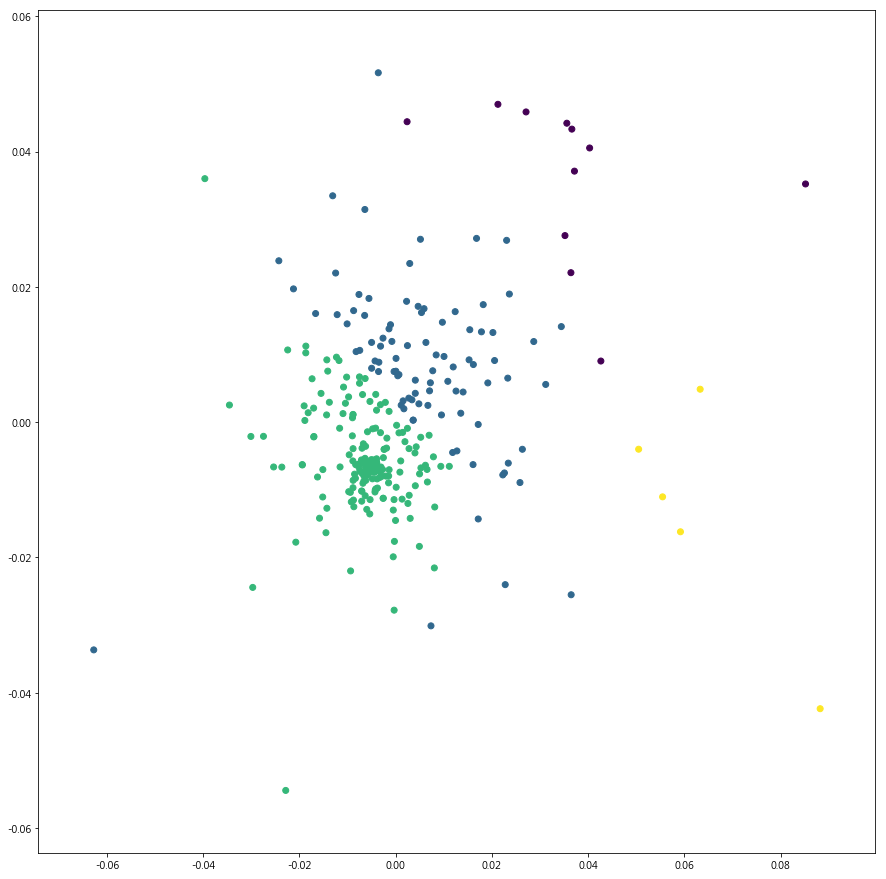

In [19]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(bottom=0.1)
plt.scatter(mds[:, 0], mds[:, 1], c=kmeans.labels_)

#for label, x, y in zip(random_names, mds[:, 0], mds[:, 1]):
#    plt.annotate(
#        label,
#        xy=(x, y), xytext=(-3, 3),
#        textcoords='offset points', ha='right', va='bottom')
plt.show()

# 使用hierarchical進行分群，並用MDS壓成2維座標，圖形化呈現

In [20]:
hierarchical = AgglomerativeClustering(n_clusters=4).fit(month_rate)

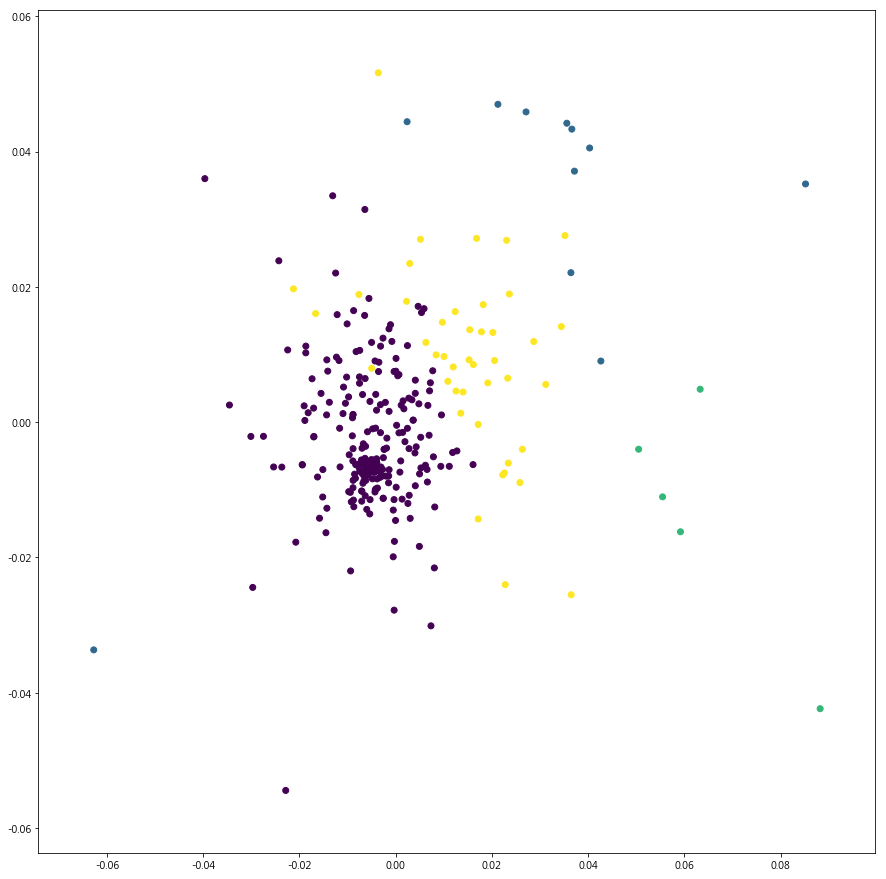

In [21]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(bottom=0.1)
plt.scatter(mds[:, 0], mds[:, 1], c=hierarchical.labels_)

#for label, x, y in zip(random_names, mds[:, 0], mds[:, 1]):
#    plt.annotate(
#        label,
#        xy=(x, y), xytext=(-3, 3),
#        textcoords='offset points', ha='right', va='bottom')
plt.show()

# 開始進行收益率回測，對比對象為台灣50，時間範圍為2017年

In [22]:
data = pd.read_sql(sql='select * from price where date between "2017-01-01" and "2017-12-31" order by date asc', con=engine,index_col='date')

In [23]:
data

,id,NAV
date,,
2017-01-03,0050 元大台灣50,72.0300
2017-01-03,0051 元大中型100,25.6800
2017-01-03,0052 富邦科技,43.4000
2017-01-03,0053 元大電子,29.8400
2017-01-03,0054 元大台商50,21.3400
2017-01-03,0055 元大MSCI金融,14.5000
2017-01-03,0056 元大高股息,23.1800
2017-01-03,0057 富邦摩台,42.2800
2017-01-03,0058 富邦發達,40.2900


# 從四個分群裡隨機選出4檔基金(K-Means)

In [24]:
camp = pd.DataFrame(data=kmeans.labels_, index=random_names,columns=['label'])

In [25]:
camp

,label
T0119A 兆豐中國 A股,0
T0594C 元大中國機債 B C,2
T4125A 凱基銀髮商機,2
EDM08 EDM 中國A USD,1
ALZFI 聯博全球不動BD$,2
T0736Y 瀚亞巴西,2
ALZCR 聯博新興價值S1$,1
NBZA2 NB新本地貨債Bzdm,2
T2055C 日盛中國戰略A股$,0
PTZ24 百達智慧城市R$,2


In [26]:
choose_name = []
for i in range(4):
    choose_name.append(camp[camp['label'] == i].sample(n=1).index[0])

In [27]:
choose_name.append('0050 元大台灣50')

In [28]:
choose_name

['T3631C 安聯新思路 $',
 'T1655E 群益環球金綻AA',
 'T0124A 兆豐三年期新債A$',
 'T3501Y 未來資產阿波羅',
 '0050 元大台灣50']

# 找出2017年所有有淨值的日子

In [29]:
year_date = pd.read_sql(sql='select distinct date from price where date between "2017-01-01" and "2017-12-31" order by date asc', con=engine,index_col='date').index

In [30]:
year_date

Index(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-09',
       '2017-01-10', '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-16',
       ...
       '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21', '2017-12-22',
       '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29'],
      dtype='object', name='date', length=246)

In [31]:
year_date_len = len(year_date)

# 拿出四檔基金與台灣50，於2017年的所有淨值

In [32]:
year_NAV = np.zeros((5,year_date_len))

In [33]:
year_NAV

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
for j in range (5):
    temp = data[data['id'] == choose_name[j]]
    year_NAV[j][0] = temp.iloc[0]['NAV']
    for i,day in enumerate(year_date[1:]):
        try:
            year_NAV[j][i+1] = temp.loc[day]['NAV']
        except:
            year_NAV[j][i+1] = year_NAV[j][i]

In [35]:
for i in year_NAV:
    print (i)

[ 9.32  9.4   9.51  9.44  9.41  9.47  9.42  9.39  9.39  9.3   9.41  9.5
  9.46  9.51  9.55  9.6   9.6   9.66  9.72  9.71  9.77  9.85  9.84  9.96
  9.99 10.   10.03  9.97  9.97 10.06 10.04 10.13 10.1  10.03  9.97  9.94
  9.95 10.1  10.14 10.17 10.07 10.16 10.33 10.31 10.36 10.45 10.38 10.41
 10.48 10.48 10.52 10.56 10.51 10.52 10.5  10.42 10.44 10.54 10.5  10.56
 10.56 10.5  10.59 10.59 10.54 10.56 10.57 10.59 10.7  10.71 10.66 10.87
 10.91 10.86 10.86 10.93 10.91 10.89 10.78 10.67 10.76 10.82 10.86 10.85
 10.98 11.1  11.01 10.96 10.98 11.11 11.14 11.1  11.11 11.06 11.1  11.21
 11.2  11.2  11.25 11.37 11.48 11.64 11.67 11.54 11.54 11.44 11.39 11.43
 11.54 11.57 11.7  11.7  11.8  11.93 11.91 11.75 11.85 11.84 11.75 11.6
 11.73 11.75 11.69 11.68 11.81 11.93 12.01 12.05 12.   12.2  12.45 12.47
 12.41 12.51 12.55 12.42 12.51 12.47 12.55 12.56 12.57 12.42 12.44 12.62
 12.6  12.63 12.56 12.38 12.61 12.68 12.71 12.73 12.66 12.75 12.83 12.82
 12.93 12.97 13.06 13.07 13.23 13.19 13.28 13.33 13.4

# 計算四檔基金與台灣50，於2017年的漲跌幅

In [36]:
year_rate = np.zeros((5,year_date_len-1))

In [37]:
year_rate

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
for j in range (5):
    for i in range (year_date_len-1):
        year_rate[j][i] = (year_NAV[j][i+1] - year_NAV[j][i]) / year_NAV[j][i]

In [39]:
for i in year_rate:
    print (i)

[ 0.00858369  0.01170213 -0.00736067 -0.00317797  0.0063762  -0.00527983
 -0.00318471  0.         -0.00958466  0.01182796  0.00956429 -0.00421053
  0.00528541  0.0042061   0.0052356   0.          0.00625     0.00621118
 -0.00102881  0.0061792   0.00818833 -0.00101523  0.01219512  0.00301205
  0.001001    0.003      -0.00598205  0.          0.00902708 -0.00198807
  0.00896414 -0.0029615  -0.00693069 -0.00598205 -0.00300903  0.00100604
  0.01507538  0.0039604   0.00295858 -0.00983284  0.00893744  0.01673228
 -0.00193611  0.00484966  0.00868726 -0.00669856  0.00289017  0.0067243
  0.          0.00381679  0.00380228 -0.00473485  0.00095147 -0.00190114
 -0.00761905  0.00191939  0.00957854 -0.00379507  0.00571429  0.
 -0.00568182  0.00857143  0.         -0.00472144  0.00189753  0.00094697
  0.00189215  0.01038716  0.00093458 -0.00466853  0.01969981  0.00367985
 -0.00458295  0.          0.00644567 -0.00182983 -0.00183318 -0.01010101
 -0.01020408  0.00843486  0.00557621  0.00369686 -0.00092081

# 計算四檔基金的合計漲跌幅，並圖像化

In [40]:
choose_rate = []
for i in range(year_date_len-1):
    temp = (year_rate[0][i] + year_rate[1][i] + year_rate[2][i] + year_rate[3][i])/4
    choose_rate.append(temp)

In [41]:
choose_rate

[0.0016036231714566009,
 0.008831109447515752,
 -0.0011584874403322363,
 -0.0038245039735170577,
 0.0027449418057370525,
 -0.0007635233586308341,
 0.0010286131307729544,
 0.0003247574711328817,
 -0.0051284202758158405,
 0.005857812046571433,
 0.0043112690879558505,
 -0.0029939268703000027,
 0.0028901819178589003,
 0.0033397020086243685,
 0.003073245924224206,
 0.006098931163651717,
 0.0014474805375224694,
 0.004819316660302822,
 -0.0005472120841963405,
 -0.00020147474884977873,
 0.005845826552440538,
 0.00010535582458688582,
 0.005176602497687449,
 -6.096863935399358e-05,
 0.0032750045894642072,
 0.000677818321203468,
 -0.0006874989420186689,
 0.0002824858757062087,
 -0.00042296077835257554,
 -0.0006148414943480114,
 0.005986545617595047,
 -0.001947756586354152,
 -0.0019247140591152595,
 -0.003841683240880203,
 -0.000562004123848119,
 0.0004484723225171939,
 0.0036525396603181645,
 0.001318055617452078,
 -0.0009637075435696602,
 -0.006030496548182083,
 0.00047269259408923986,
 0.006899

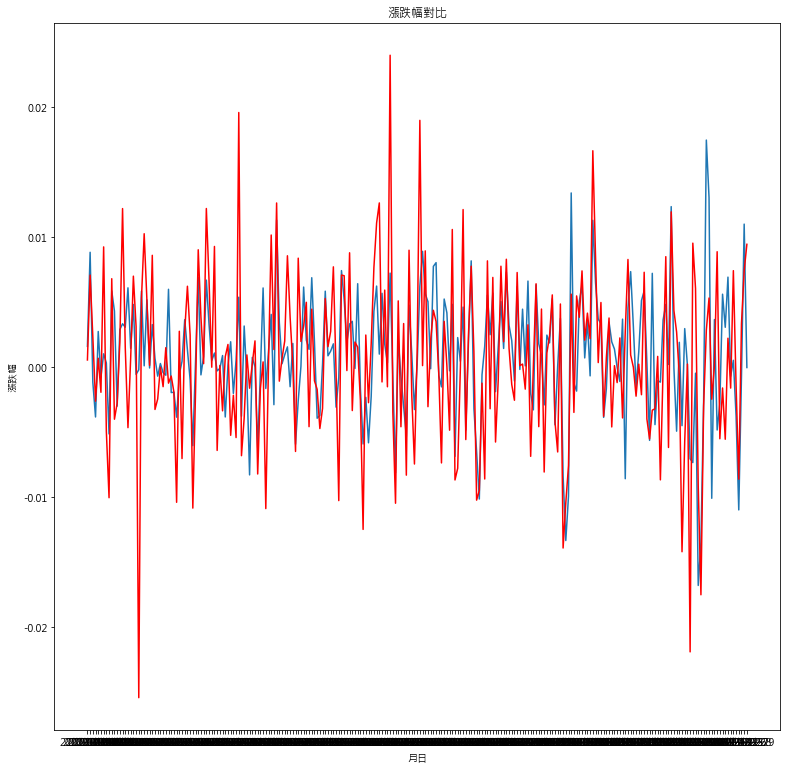

In [42]:
plt.figure(figsize=(13, 13))
plt.xlabel('月日')
plt.ylabel('漲跌幅')
plt.title('漲跌幅對比')
plt.plot(year_date[1:], choose_rate, label='四檔基金')
plt.plot(year_date[1:],year_rate[-1], color='r', label='台灣50')
plt.show()

# 計算四檔基金與台灣50，自2017年初至年尾的收益率，並圖像化

In [43]:
choose_profit = []
compare__profit = []
start = (year_NAV[0][0] + year_NAV[1][0] + year_NAV[2][0] + year_NAV[3][0])/4
for i in range(year_date_len):
    temp = (year_NAV[0][i] + year_NAV[1][i] + year_NAV[2][i] + year_NAV[3][i])/4
    temp = (temp-start)/start*100
    choose_profit.append(temp)
    compare__profit.append((year_NAV[4][i]-year_NAV[4][0])/year_NAV[4][0]*100)

In [44]:
choose_profit

[0.0,
 0.1733591246856444,
 1.033101012211104,
 0.9104745265179761,
 0.5444941521816521,
 0.8233880178730999,
 0.7417274599225974,
 0.8298991587063481,
 0.8727641691919943,
 0.371406325030736,
 0.9427589331495847,
 1.3673395749852955,
 1.075152130092604,
 1.3540459957840518,
 1.6828586078638315,
 1.9929516900479938,
 2.5827525305277694,
 2.741190290803839,
 3.2222008198611687,
 3.15980238687572,
 3.1576320065979706,
 3.7430920865222097,
 3.75095971502908,
 4.287586238703843,
 4.299252032696793,
 4.623452586686345,
 4.696974218595288,
 4.610972900089267,
 4.638102653561211,
 4.626436859568261,
 4.567293996999456,
 5.1712023092846415,
 4.976410679356155,
 4.769410660365337,
 4.3855246487375235,
 4.316343777384098,
 4.352426349501768,
 4.75069113046972,
 4.89095195591959,
 4.798439496580302,
 4.170657001239835,
 4.249061988773714,
 4.978038464564485,
 4.908043700606895,
 5.0190043923070915,
 5.710813105841319,
 5.996489409900743,
 6.0626860083722525,
 6.18721157680842,
 6.152485492364335,

In [45]:
compare__profit

[0.0,
 0.05553241704844099,
 0.7635707344162115,
 0.9995835068721349,
 0.7358045258919911,
 0.8052200472025521,
 0.6108565875329692,
 1.541024573094543,
 1.0412328196584755,
 0.027766208524220494,
 0.7080383173677705,
 0.3054282937664846,
 0.027766208524220494,
 0.2221296681938034,
 1.4438428432597417,
 1.5965569901430037,
 1.1245314452311568,
 1.193946966541718,
 1.9019852839094884,
 2.2212966819380733,
 -0.37484381507704573,
 0.1527141468832423,
 1.1800638622795978,
 1.7076218242399057,
 1.7215049285020059,
 2.596140497015139,
 2.262945994724414,
 2.0130501180063898,
 2.0130501180063898,
 1.860335971123148,
 2.0130501180063898,
 1.8881021796473683,
 1.8186866583368073,
 1.6243231986672244,
 0.5692072747466286,
 0.8468693599888928,
 0.1388310426211222,
 0.41649312786338627,
 1.0412328196584755,
 1.2911286963764996,
 0.1943634596695829,
 0.0,
 0.9024017770373535,
 1.2911286963764996,
 1.3188949049007397,
 2.554491184228798,
 3.2347632930723282,
 3.2347632930723282,
 4.192697487158123,


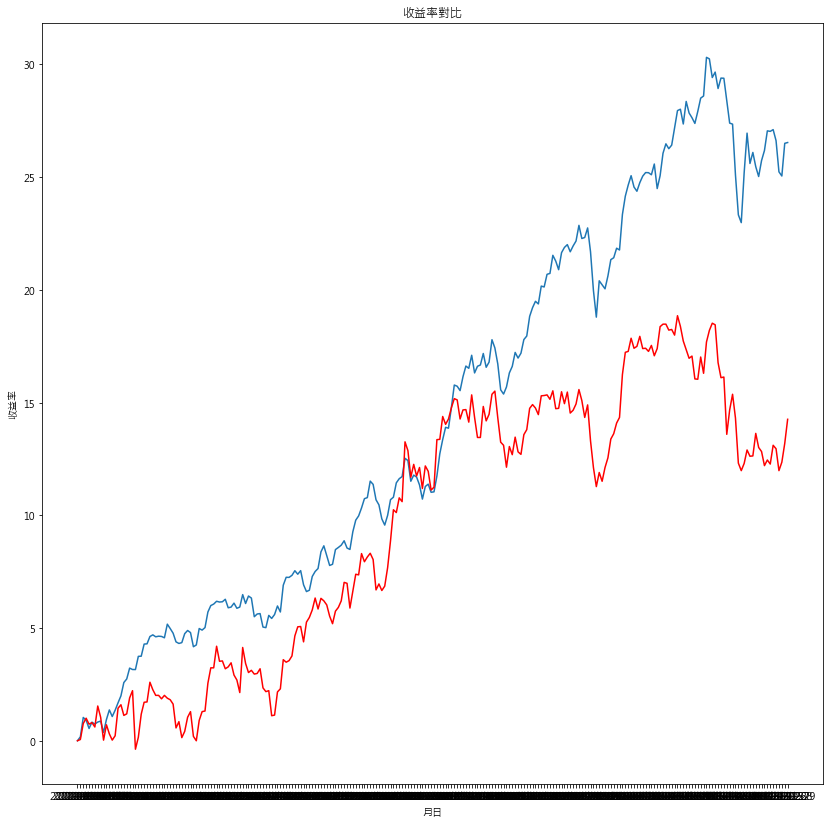

In [46]:
plt.figure(figsize=(14, 14))
plt.xlabel('月日')
plt.ylabel('收益率')
plt.title('收益率對比')
plt.plot(year_date, choose_profit, label='四檔基金')
plt.plot(year_date, compare__profit, color = 'r', label='台灣50')
plt.show()

In [47]:
camp = pd.DataFrame(data=hierarchical.labels_, index=random_names,columns=['label'])

In [48]:
camp

,label
T0119A 兆豐中國 A股,1
T0594C 元大中國機債 B C,0
T4125A 凱基銀髮商機,0
EDM08 EDM 中國A USD,3
ALZFI 聯博全球不動BD$,0
T0736Y 瀚亞巴西,0
ALZCR 聯博新興價值S1$,3
NBZA2 NB新本地貨債Bzdm,0
T2055C 日盛中國戰略A股$,1
PTZ24 百達智慧城市R$,0


# 從四個分群裡隨機選出4檔基金(Hierarchical)

In [49]:
choose_name = []
for i in range(4):
    choose_name.append(camp[camp['label'] == i].sample(n=1).index[0])

In [50]:
choose_name.append('0050 元大台灣50')

In [51]:
choose_name

['PTZ36 百達歐高債HR $',
 '008201 BP上證50',
 'T1005Y 富邦長紅',
 'FTZ08 富達日本基金',
 '0050 元大台灣50']

# 找出2017年所有有淨值的日子

In [52]:
year_date = pd.read_sql(sql='select distinct date from price where date between "2017-01-01" and "2017-12-31" order by date asc', con=engine,index_col='date').index

In [53]:
year_date

Index(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-09',
       '2017-01-10', '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-16',
       ...
       '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21', '2017-12-22',
       '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29'],
      dtype='object', name='date', length=246)

In [54]:
year_date_len = len(year_date)

# 拿出四檔基金與台灣50，於2017年的所有淨值

In [55]:
year_NAV = np.zeros((5,year_date_len))

In [56]:
year_NAV

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
for j in range (5):
    temp = data[data['id'] == choose_name[j]]
    year_NAV[j][0] = temp.iloc[0]['NAV']
    for i,day in enumerate(year_date[1:]):
        try:
            year_NAV[j][i+1] = temp.loc[day]['NAV']
        except:
            year_NAV[j][i+1] = year_NAV[j][i]

In [58]:
for i in year_NAV:
    print (i)

[315.4  315.96 316.31 316.23 316.19 316.32 316.46 316.34 316.52 316.54
 316.54 316.58 316.63 316.68 317.88 316.53 316.49 317.03 317.23 317.3
 317.22 317.25 316.15 317.59 317.72 317.93 318.24 318.44 318.44 317.45
 318.78 318.98 318.98 318.98 318.98 319.87 319.64 319.83 319.76 319.4
 318.59 318.51 317.24 316.65 318.08 318.89 319.01 319.27 319.04 318.93
 318.93 318.93 318.93 318.93 318.93 318.93 318.93 318.36 319.4  319.63
 319.8  320.01 318.97 320.23 320.23 320.23 320.39 320.5  320.65 320.87
 321.84 322.17 322.75 323.1  323.1  323.92 324.34 326.01 323.44 323.88
 325.3  325.72 324.81 324.64 325.71 325.79 325.43 324.7  325.22 325.65
 325.65 325.65 325.65 325.65 325.65 325.65 327.35 327.35 327.35 327.39
 326.17 327.16 326.98 327.04 327.41 328.16 327.67 328.13 328.31 328.57
 328.27 327.92 327.92 327.92 327.92 327.92 327.92 327.92 327.48 327.52
 327.74 326.92 326.29 326.28 326.13 326.94 327.39 327.72 327.95 328.27
 328.63 328.93 329.46 329.46 329.46 329.46 329.46 329.46 329.46 329.46
 331.92 

# 計算四檔基金與台灣50，於2017年的漲跌幅

In [59]:
year_rate = np.zeros((5,year_date_len-1))

In [60]:
year_rate

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [61]:
for j in range (5):
    for i in range (year_date_len-1):
        year_rate[j][i] = (year_NAV[j][i+1] - year_NAV[j][i]) / year_NAV[j][i]

In [62]:
for i in year_rate:
    print (i)

[ 1.77552315e-03  1.10773516e-03 -2.52916443e-04 -1.26490213e-04
  4.11145198e-04  4.42589782e-04 -3.79194843e-04  5.69008029e-04
  6.31871604e-05  0.00000000e+00  1.26366336e-04  1.57937962e-04
  1.57913022e-04  3.78931413e-03 -4.24688562e-03 -1.26370328e-04
  1.70621505e-03  6.30855124e-04  2.20660089e-04 -2.52127324e-04
  9.45715907e-05 -3.46729708e-03  4.55479994e-03  4.09332788e-04
  6.60959335e-04  9.75057403e-04  6.28456511e-04  0.00000000e+00
 -3.10890592e-03  4.18963616e-03  6.27391932e-04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.79014358e-03 -7.19042111e-04
  5.94418721e-04 -2.18866273e-04 -1.12584438e-03 -2.53600501e-03
 -2.51106438e-04 -3.98731594e-03 -1.85979069e-03  4.51602716e-03
  2.54652918e-03  3.76305309e-04  8.15021473e-04 -7.20393397e-04
 -3.44784353e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.78722604e-03  3.26674205e-03  7.20100188e-04  5.31864969e-04
  6.56660413e-04 -3.24989

# 計算四檔基金的合計漲跌幅，並圖像化

In [63]:
choose_rate = []
for i in range(year_date_len-1):
    temp = (year_rate[0][i] + year_rate[1][i] + year_rate[2][i] + year_rate[3][i])/4
    choose_rate.append(temp)

In [64]:
choose_rate

[0.006154790505042557,
 0.003300051853140777,
 0.0011608341610264928,
 -0.002447773231588448,
 -0.003687639721740339,
 -0.0013366773118062291,
 -0.004020918529733948,
 0.005204218946987683,
 -0.0018982048804782954,
 -0.004070694145548394,
 0.004115715953654989,
 0.0014272635104807642,
 0.0017378044858528136,
 -0.0016315709006624658,
 0.0009924137125387304,
 0.000725120666756446,
 -0.002124763545421098,
 -0.0005841535216073472,
 0.001235101398905746,
 0.0009254516525801662,
 0.003894497552054465,
 0.0028155336143697125,
 0.005700940773792208,
 -0.002091615663475414,
 0.0022170150062496377,
 -0.0023523888881916994,
 -0.002254813259810622,
 0.0013814880599960584,
 0.003626012681079748,
 0.0033212263527019606,
 0.0014841394731236921,
 -0.0023878039433776724,
 -0.0010504409885532594,
 -0.004800909100928106,
 0.0011016502966080188,
 -0.0008229026332936498,
 -0.0008766949226310221,
 0.001687061214481544,
 0.0013046605879652544,
 -0.0031657700456144446,
 0.00077342894336803,
 0.003386250604708

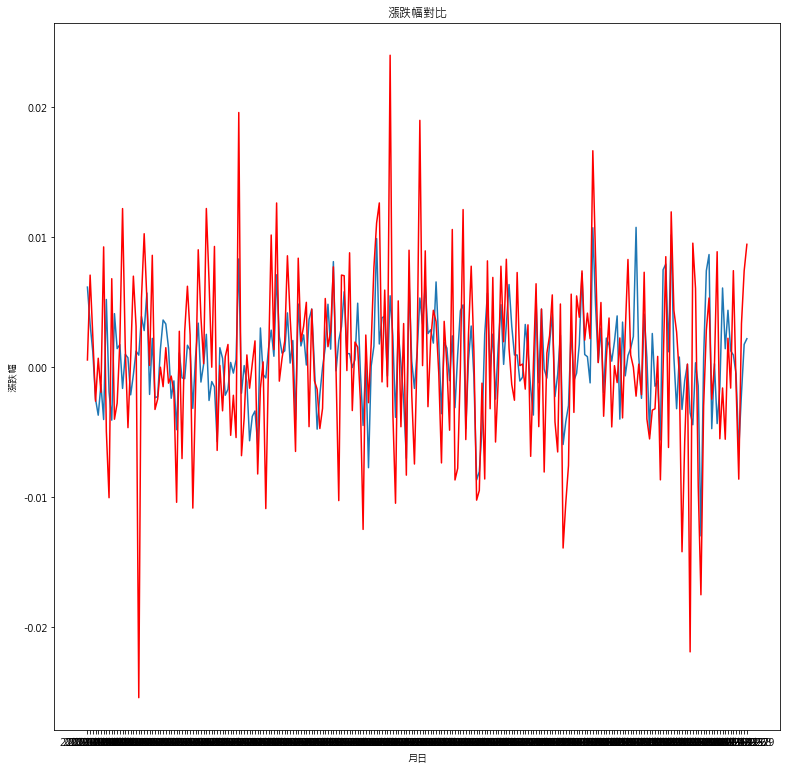

In [65]:
plt.figure(figsize=(13, 13))
plt.xlabel('月日')
plt.ylabel('漲跌幅')
plt.title('漲跌幅對比')
plt.plot(year_date[1:], choose_rate, label='四檔基金')
plt.plot(year_date[1:],year_rate[-1], color='r', label='台灣50')
plt.show()

# 計算四檔基金與台灣50，自2017年初至年尾的收益率，並圖像化

In [66]:
choose_profit = []
compare__profit = []
start = (year_NAV[0][0] + year_NAV[1][0] + year_NAV[2][0] + year_NAV[3][0])/4
for i in range(year_date_len):
    temp = (year_NAV[0][i] + year_NAV[1][i] + year_NAV[2][i] + year_NAV[3][i])/4
    temp = (temp-start)/start*100
    choose_profit.append(temp)
    compare__profit.append((year_NAV[4][i]-year_NAV[4][0])/year_NAV[4][0]*100)

In [67]:
choose_profit

[0.0,
 0.5803289504237928,
 0.6727494039591009,
 0.9365410939064407,
 0.7638133148332926,
 0.44679727459406915,
 0.4351948450102133,
 -0.06453951201809176,
 0.48457299787469393,
 0.29302917412565443,
 -0.2648450054253695,
 0.069343268970963,
 0.3924557715224544,
 0.5319083570847987,
 0.2504816125430001,
 0.20881181385872805,
 0.16599294374386497,
 0.1384950260368396,
 -0.01007033434307396,
 0.07363632751025842,
 0.14251677604392626,
 0.4841580554136613,
 0.529306987040548,
 1.1442517143108404,
 0.9939467874596012,
 1.070487712197197,
 0.8489882346257055,
 0.7093441371582748,
 0.7540302483478483,
 1.0323449244318024,
 1.4723275670694476,
 1.5431071753286676,
 1.3333218426190323,
 1.3007648187523477,
 1.114248182512144,
 1.4312003854496296,
 1.375183153208409,
 1.1731061746789821,
 1.2196754862686687,
 1.2941736173518703,
 1.0529484135552816,
 1.2535411748202072,
 1.2628295022174783,
 1.0327119889165541,
 1.219755282895791,
 1.352584748406816,
 1.0983048164126936,
 1.0779407171705997,
 0

In [68]:
compare__profit

[0.0,
 0.05553241704844099,
 0.7635707344162115,
 0.9995835068721349,
 0.7358045258919911,
 0.8052200472025521,
 0.6108565875329692,
 1.541024573094543,
 1.0412328196584755,
 0.027766208524220494,
 0.7080383173677705,
 0.3054282937664846,
 0.027766208524220494,
 0.2221296681938034,
 1.4438428432597417,
 1.5965569901430037,
 1.1245314452311568,
 1.193946966541718,
 1.9019852839094884,
 2.2212966819380733,
 -0.37484381507704573,
 0.1527141468832423,
 1.1800638622795978,
 1.7076218242399057,
 1.7215049285020059,
 2.596140497015139,
 2.262945994724414,
 2.0130501180063898,
 2.0130501180063898,
 1.860335971123148,
 2.0130501180063898,
 1.8881021796473683,
 1.8186866583368073,
 1.6243231986672244,
 0.5692072747466286,
 0.8468693599888928,
 0.1388310426211222,
 0.41649312786338627,
 1.0412328196584755,
 1.2911286963764996,
 0.1943634596695829,
 0.0,
 0.9024017770373535,
 1.2911286963764996,
 1.3188949049007397,
 2.554491184228798,
 3.2347632930723282,
 3.2347632930723282,
 4.192697487158123,


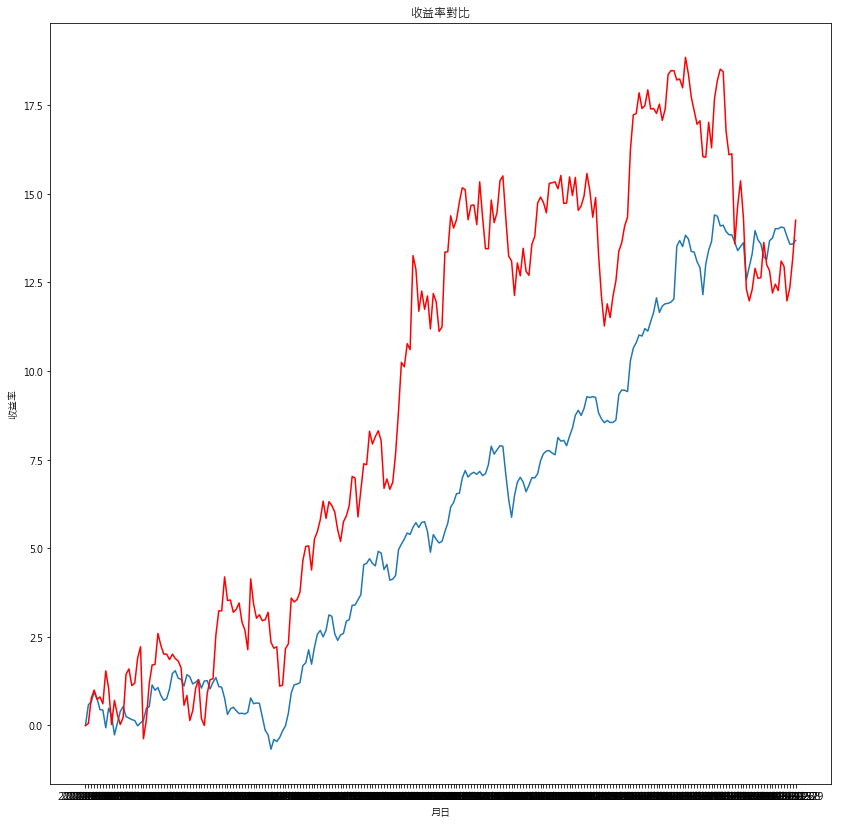

In [69]:
plt.figure(figsize=(14, 14))
plt.xlabel('月日')
plt.ylabel('收益率')
plt.title('收益率對比')
plt.plot(year_date, choose_profit, label='四檔基金')
plt.plot(year_date, compare__profit, color = 'r', label='台灣50')
plt.show()